In [1]:
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/"
os.chdir(running_path)

In [2]:


import torch
import matplotlib.pyplot as plt
import pandas as pd
# import torch.nn.functional as F
# import hydra
# from src.utils import get_cfg_from_ckpt_path 
# from src.select_outputs_on_params import select_outputs_on_params
from sklearn.decomposition import PCA
# import numpy as np
# import scipy.ndimage
from tqdm import tqdm
from pathlib import Path
import cartopy.crs as ccrs
# import re
from src.utils import *


In [3]:
plt.style.use('ggplot')

In [4]:
cmap = plt.get_cmap('viridis')

In [ ]:
gpu = 0
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [6]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    pca_dict = {}
    print("Initializing datamodule")

Initializing datamodule


In [7]:
save_fig = False

In [8]:
ckpt_dict = {}

base_dir = "outputs/AE/AE_CNN_3D/visualisation/"


# List the first-level directories in the base directory
first_level_dirs = next(os.walk(base_dir))[1]

# Iterate through the first-level directories
for dir_name in first_level_dirs:
    if dir_name == "mute":
        continue
    # Create the relative path
    relative_path = os.path.join(base_dir, dir_name)
    # Add to the dictionary
    ckpt_dict[dir_name] = relative_path

# Print the dictionary
print(ckpt_dict)

{'interp_size_3': 'outputs/AE/AE_CNN_3D/visualisation/interp_size_3'}


In [9]:
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))
    print(f"Model {model_carac} with {len(ckpt_list)} checkpoints")

Model interp_size_3 with 1 checkpoints


In [10]:
verbose = True


ae_rmse_dict = {"SSP":{},
                "ECS":{},
                "n_min_max":{},
                "ssp_min_max":{}}

pca_rmse_dict = {"SSP": {"t":[],"lat":[],"lon":[]},
                "ECS": {"t":[],"lat":[],"lon":[]},
                "n_min_max": {"t":[],"lat":[],"lon":[]},
                "ssp_min_max": {"t":[],"lat":[],"lon":[]}}


        
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))


    for ckpt_path in tqdm(ckpt_list):
        ckpt_path = str(ckpt_path)
        
        model_name = " ".join((ckpt_path.split("AE")[-1]).split("/")).replace("_", "  ")
        print(f"\n{model_name}")
        

        if model_carac not in ae_rmse_dict["SSP"].keys():
            for sub_dic in ae_rmse_dict.values():
                sub_dic[model_carac] = {}
            for sub_dic in pca_rmse_dict.values():
                sub_dic[model_carac] = {}
        
        
        try:
            cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)        
    
        except:
            print(f"Can't load config")
            continue
        
        #cfg.dtype = "float64"
        
        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_ssp_arr, _ = loading_datamodule_phase(dm, phase = "test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)

            ssp_pca_test_arr = pca_dict[cfg.datamodule]
        
        else:
            if verbose:
                print("Inititing datamodule; Generating train and test datasets")
            
            
            dm = hydra.utils.call(cfg.datamodule)  
            train_ssp_arr, test_ssp_arr, dm = loading_datamodule(dm)
            train_ssp_arr = unorm_ssp_arr_3D(train_ssp_arr,dm)
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)
            dm_dict[cfg.datamodule] = dm

            if verbose:
                print("Computing PCA")
            pca = PCA(n_components=train_ssp_arr.shape[1])
            pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,train_ssp_arr.shape[1]))
            ssp_pca_test_arr = pca.inverse_transform(pca.transform(unorm_ssp_arr_3D(test_ssp_arr,dm).transpose(0,2,3,1).reshape(-1,test_ssp_arr.shape[1]))).reshape(test_ssp_arr.shape[0],test_ssp_arr.shape[2],test_ssp_arr.shape[3],test_ssp_arr.shape[1]).transpose(0,3,1,2)

            pca_dict[cfg.datamodule] = ssp_pca_test_arr



        input_test_shape = test_ssp_tens.shape
        depth_array = dm.depth_array


        
        if verbose:
            print("Loading model, generating AE output")      
        
        try:
            lit_model = load_model(ckpt_path, dm, device, verbose = True)    
        except:
            print(f"Can't load model")
            continue

        ssp_ae_test_arr = lit_model(test_ssp_tens).detach().cpu().numpy()



        try:
            bottleneck_shape = lit_model.model_AE.bottleneck_shape
        except:
            bottleneck_shape = lit_model.encoder.net(test_ssp_tens.unsqueeze(1)).shape
            
        compression_rate_ae = test_ssp_tens.numel()/bottleneck_shape.numel()

        if bottleneck_shape in ae_rmse_dict["SSP"][model_carac].keys():
            continue

        else:
            for sub_dic in ae_rmse_dict.values():
                sub_dic[model_carac][bottleneck_shape] = {"t":[],"lat":[],"lon":[]}


            

        test_ssp_arr = unorm_ssp_arr_3D(test_ssp_arr, dm)
        ssp_ae_test_arr = unorm_ssp_arr_3D(ssp_ae_test_arr, dm)



        ae_rmse_dict["SSP"][model_carac][bottleneck_shape]["t"] = np.sqrt(np.mean((test_ssp_arr-ssp_ae_test_arr)**2,axis=(1,2,3)))
        ae_rmse_dict["SSP"][model_carac][bottleneck_shape]["lat"] = np.sqrt(np.mean((test_ssp_arr-ssp_ae_test_arr)**2,axis=(0,1,3)))
        ae_rmse_dict["SSP"][model_carac][bottleneck_shape]["lon"] = np.sqrt(np.mean((test_ssp_arr-ssp_ae_test_arr)**2,axis=(0,1,2)))



pca_rmse_dict["SSP"]["t"] = np.sqrt(np.mean((test_ssp_arr-ssp_pca_test_arr)**2,axis=(1,2,3)))
pca_rmse_dict["SSP"]["lat"] = np.sqrt(np.mean((test_ssp_arr-ssp_pca_test_arr)**2,axis=(0,1,3)))
pca_rmse_dict["SSP"]["lon"] = np.sqrt(np.mean((test_ssp_arr-ssp_pca_test_arr)**2,axis=(0,1,2)))

  0%|          | 0/1 [00:00<?, ?it/s]


  CNN  3D visualisation interp  size  3 final  upsample  upsample act  fn  Elu  final  act  fn  Linear lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-04  15-34 checkpoints val  loss=0.25-epoch=04.ckpt
Inititing datamodule; Generating train and test datasets
Computing PCA
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniconda3/envs/fsc_env/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
100%|██████████| 1/1 [03:29<00:00, 209.17s/it]


In [11]:
for model in ae_rmse_dict["SSP"].keys():

    if len(ae_rmse_dict["SSP"][model].keys()) > 1:
        alpha = 0.5
    else:
        alpha = 1
    for bottleneck_shape in ae_rmse_dict["SSP"][model].keys():

        # for coord in ["t","lat","lon"]:
        #     ae_rmse_dict["SSP"][model][bottleneck_shape][coord] = np.mean(ae_rmse_dict["SSP"][model][bottleneck_shape][coord])

        # bins = len(dm.test_ds.input.coords["time"].values)
        #labels = [pd.to_datetime(t).strftime('%Y-%m-%d') for t in dm.test_ds.input.coords["time"].values]
        # plt.hist(ae_rmse_dict["SSP"][model][bottleneck_shape]["t"], bins=bins, alpha=alpha)
        # plt.xticks(ticks=np.arange(bins), labels=labels, rotation=45)
        # plt.plot(np.arange(37),ae_rmse_dict["SSP"][model][bottleneck_shape]["t"])
        continue

In [12]:
# Extract the time coordinates and convert them to a pandas datetime index
time_coords = pd.to_datetime(dm.test_ds.input.coords["time"].values)

# Create a DataFrame with time coordinates and corresponding RMSE values
df = pd.DataFrame({
    'time': time_coords,
    'rmse': ae_rmse_dict["SSP"][model][bottleneck_shape]["t"]
})

# Sort the DataFrame by time
df_sorted = df.sort_values(by='time')

# Update the ae_rmse_dict with the sorted RMSE values
ae_rmse_dict["SSP"][model][bottleneck_shape]["t"] = df_sorted['rmse'].values

# Print sorted time coordinates and RMSE values for verification


<Axes: xlabel='time'>

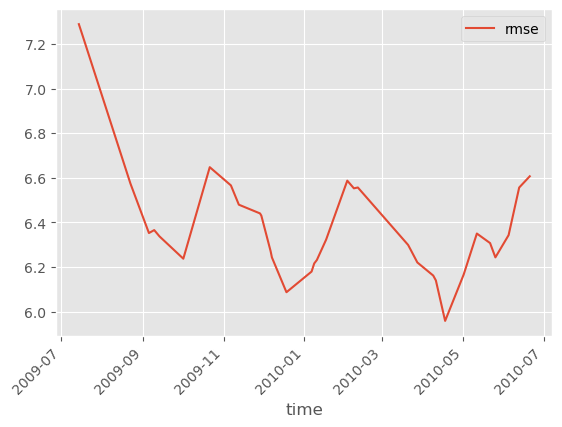

In [13]:
df_sorted.plot(x='time', y='rmse', kind='line', rot=45)

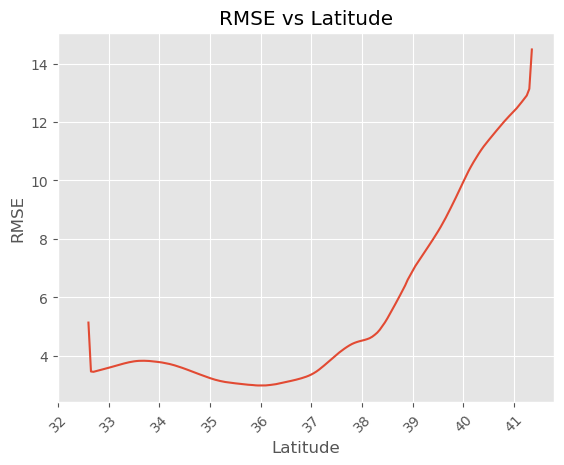

In [14]:
plt.plot(dm.test_ds.input.coords["lat"].values, ae_rmse_dict["SSP"][model][bottleneck_shape]["lat"])
plt.xticks(ticks=np.arange(np.floor(min(dm.test_ds.input.coords["lat"].values)), np.ceil(max(dm.test_ds.input.coords["lat"].values)), 1),rotation=45)
plt.xlabel('Latitude')
plt.ylabel('RMSE')
plt.title('RMSE vs Latitude')
plt.grid(True)
plt.show()

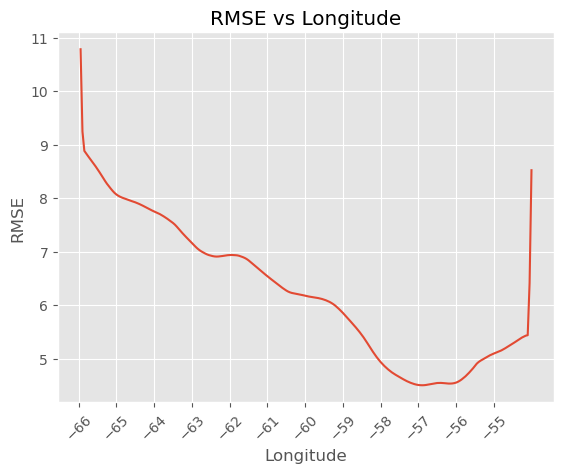

In [15]:
plt.plot(dm.test_ds.input.coords["lon"].values, ae_rmse_dict["SSP"][model][bottleneck_shape]["lon"])
plt.xticks(ticks=np.arange(np.floor(min(dm.test_ds.input.coords["lon"].values)), np.ceil(max(dm.test_ds.input.coords["lon"].values)), 1),rotation=45)
plt.xlabel('Longitude')
plt.ylabel('RMSE')
plt.title('RMSE vs Longitude')
plt.grid(True)
plt.show()

In [16]:
rmse_lat_lon = np.sqrt(np.mean((test_ssp_arr-ssp_ae_test_arr)**2,axis=(0,1)))

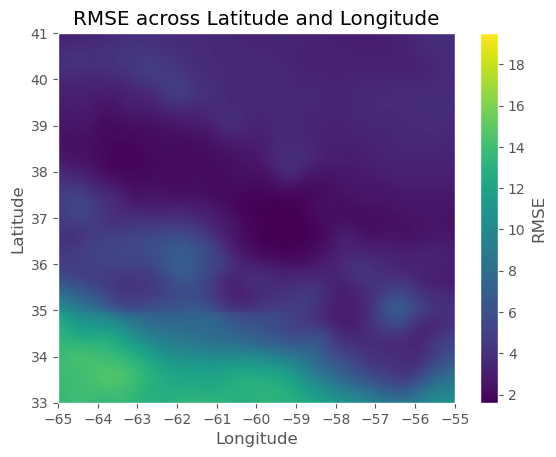

In [17]:
projection = ccrs.PlateCarree()
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([np.ceil(min(dm.test_ds.input.coords["lon"].values)), np.floor(max(dm.test_ds.input.coords["lon"].values)), np.ceil(min(dm.test_ds.input.coords["lat"].values)), np.floor(max(dm.test_ds.input.coords["lat"].values))])
#ax.set_extent([-80, -45, 15, 55])
ax.coastlines()

plt.imshow(rmse_lat_lon, aspect='auto', extent=[dm.test_ds.input.coords["lon"].values.min(), dm.test_ds.input.coords["lon"].values.max(), dm.test_ds.input.coords["lat"].values.min(), dm.test_ds.input.coords["lat"].values.max()])
plt.colorbar(label='RMSE')
plt.xticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lon"].values)), np.ceil(max(dm.test_ds.input.coords["lon"].values)), 1))
plt.yticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lat"].values)), np.ceil(max(dm.test_ds.input.coords["lat"].values)), 1))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('RMSE across Latitude and Longitude')
plt.grid(False)
plt.show()

# Input data complexity

In [18]:
# input_da = xr.open_dataarray("/Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc")
# input_da

In [19]:
# Compute mean along the depth axis
mean = np.mean(train_ssp_arr, axis=1, keepdims=True)

# Center the signals
centered_arr = train_ssp_arr - mean

# Compute autocorrelation using FFT for efficiency
fft_arr = np.fft.fft(centered_arr, axis=1)
power_spectrum = np.abs(fft_arr)**2


In [26]:
cumulated_power = np.sum(power_spectrum, axis=1)

In [27]:
t_max, lat_max, lon_max = np.unravel_index(np.argmax(cumulated_power), cumulated_power.shape)
t_min, lat_min, lon_min = np.unravel_index(np.argmin(cumulated_power), cumulated_power.shape)
print(t_max, lat_max, lon_max)
print(t_min, lat_min, lon_min)

156 169 1
14 98 89


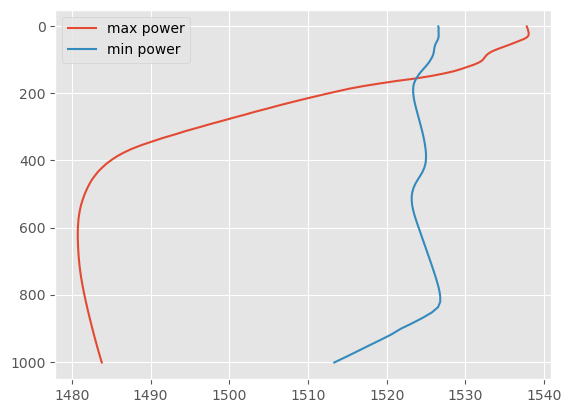

In [31]:
plt.plot(train_ssp_arr[t_max,:, lat_max, lon_max],depth_array,label="max power")
plt.plot(train_ssp_arr[t_min,:, lat_min, lon_min],depth_array,label="min power")
plt.gca().invert_yaxis()
plt.legend()

In [32]:
autocorr = np.fft.ifft(power_spectrum, axis=1).real
max_autocorr_values = np.max(autocorr[:, :autocorr.shape[1] // 2, :, :], axis=1)
t_max, lat_max, lon_max = np.unravel_index(np.argmax(max_autocorr_values), max_autocorr_values.shape)
print(t_max, lat_max, lon_max)
t_min, lat_min, lon_min = np.unravel_index(np.argmin(max_autocorr_values), max_autocorr_values.shape)
print(t_min, lat_min, lon_min)

156 169 1
14 98 89


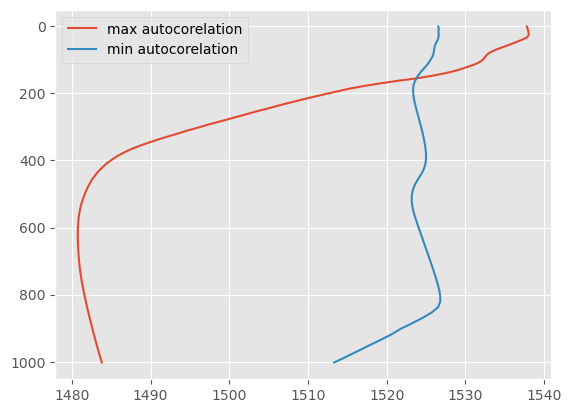

In [34]:
plt.plot(train_ssp_arr[t_max,:, lat_max, lon_max],depth_array,label="max autocorelation")
plt.plot(train_ssp_arr[t_min,:, lat_min, lon_min],depth_array,label="min autocorelation")
plt.gca().invert_yaxis()
plt.legend()

In [35]:
from scipy.stats import entropy
hist, bin_edges = np.histogram(train_ssp_arr, bins=50, density=True)
signal_entropy = entropy(hist)

In [58]:
def get_min_max_idx(arr,axs=1):
    grad = np.diff(arr,axis=axs)
    grad_sign = np.sign(grad)
    min_max = np.diff(grad_sign,axis=axs) 
    min_max = np.abs(np.sign(min_max))
    min_max = np.pad(min_max, ((0,0),(1,1),(0,0),(0,0)), 'constant', constant_values=1)
    return min_max


In [59]:
train_min_max_idx = get_min_max_idx(train_ssp_arr)

In [60]:
train_min_max_idx[t_max, :, lat_max, lon_max]

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.], dtype=float32)

In [61]:
np.argmax(np.sum(train_min_max_idx,axis=1))

5912808

In [62]:
n_min_max = np.sum(train_min_max_idx,axis=1)
t_max,lat_max,lon_max = np.unravel_index(np.argmax(n_min_max),n_min_max.shape)
print(t_max, lat_max, lon_max)
t_min,lat_min,lon_min = np.unravel_index(np.argmin(n_min_max),n_min_max.shape)
print(t_min, lat_min, lon_min)

141 102 168
0 0 143


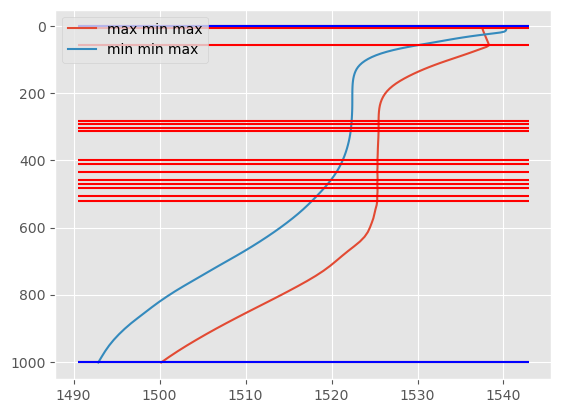

In [67]:
plt.plot(train_ssp_arr[t_max,:, lat_max, lon_max],depth_array,label="max min max")
plt.plot(train_ssp_arr[t_min,:, lat_min, lon_min],depth_array,label="min min max")
plt.gca().invert_yaxis()
plt.legend()

x_min, x_max = plt.gca().get_xlim()
non_zero_indices_max = train_min_max_idx[t_max,:,lat_max,lon_max] != 0
non_zero_indices_min = train_min_max_idx[t_min,:,lat_min,lon_min] != 0

plt.hlines(train_min_max_idx[t_max,:, lat_max, lon_max][non_zero_indices_max] * dm.depth_array[non_zero_indices_max], x_min, x_max, colors="r")

plt.hlines(train_min_max_idx[t_min,:, lat_min, lon_min][non_zero_indices_min] * dm.depth_array[non_zero_indices_min], x_min, x_max, colors="b")



In [55]:
# Normalize the array along the depth dimension
prob_dist = train_ssp_arr / np.sum(train_ssp_arr, axis=1, keepdims=True)

# Compute entropy for all (t, lat, lon) at once
entropy_values = -np.sum(prob_dist * np.log(prob_dist + 1e-9), axis=1)  # Add a small constant to avoid log(0)

# Find the maximum entropy and its indices
max_entropy = np.max(entropy_values)
t_max, lat_max, lon_max = np.unravel_index(np.argmax(entropy_values), entropy_values.shape)

print(f"Maximum Entropy: {max_entropy}")
print(f"Indices (t, lat, lon): ({t_max}, {lat_max}, {lon_max})")

max_entropy = np.min(entropy_values)
t_min, lat_min, lon_min = np.unravel_index(np.argmin(entropy_values), entropy_values.shape) 
print(f"Minimum Entropy: {max_entropy}")
print(f"Indices (t, lat, lon): ({t_min}, {lat_min}, {lon_min})")

Maximum Entropy: 4.672830104827881
Indices (t, lat, lon): (188, 52, 232)
Minimum Entropy: 4.672703266143799
Indices (t, lat, lon): (156, 169, 1)


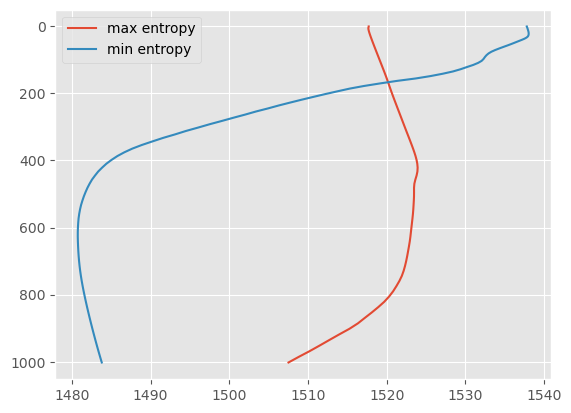

In [56]:
plt.plot(train_ssp_arr[t_max,:, lat_max, lon_max],depth_array,label="max entropy")
plt.plot(train_ssp_arr[t_min,:, lat_min, lon_min],depth_array,label="min entropy")
plt.gca().invert_yaxis()
plt.legend()